In [12]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os

# *Load Data from API into CSV file*

In [7]:
base_url = "https://dummyjson.com/users"
limit = 30          # عدد اليوزرز في كل request
skip = 0
all_users = []

while True:
    params = {
        "limit": limit,
        "skip": skip
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    users = data.get("users", [])

    if not users:   # لو مفيش داتا جديدة نوقف اللوب
        break

    all_users.extend(users)
    skip += limit

# تحويل الداتا لـ DataFrame
df = pd.json_normalize(all_users)

# حفظ في CSV
df.to_csv("users_data.csv", index=False)

print("✅ Data fetched and saved successfully")
print("Total users:", df.shape[0])

✅ Data fetched and saved successfully
Total users: 208


# *Load CSV*

In [ ]:
df = pd.read_csv("users_data.csv")

print("✅ Loaded users_data.csv successfully")

# (اختياري) تأكد إن الأعمدة الرقمية Numeric
for col in ["age", "height", "weight"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")


========== Basic Exploration ==========
Shape: (100, 52)

Columns:
 ['id', 'firstName', 'lastName', 'maidenName', 'age', 'gender', 'email', 'phone', 'username', 'password', 'birthDate', 'image', 'bloodGroup', 'height', 'weight', 'eyeColor', 'ip', 'macAddress', 'university', 'ein', 'ssn', 'userAgent', 'role', 'hair.color', 'hair.type', 'address.address', 'address.city', 'address.state', 'address.stateCode', 'address.postalCode', 'address.coordinates.lat', 'address.coordinates.lng', 'address.country', 'bank.cardExpire', 'bank.cardNumber', 'bank.cardType', 'bank.currency', 'bank.iban', 'company.department', 'company.name', 'company.title', 'company.address.address', 'company.address.city', 'company.address.state', 'company.address.stateCode', 'company.address.postalCode', 'company.address.coordinates.lat', 'company.address.coordinates.lng', 'company.address.country', 'crypto.coin', 'crypto.wallet', 'crypto.network']

Data Types:
 id                                   int64
firstName      

# *Basic Data Exploration*

In [8]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())

print("\nData Types:\n", df.dtypes)

print("\nMissing Values per Column (Top 20):\n", df.isnull().sum().sort_values(ascending=False).head(20))

print("\nDuplicate Rows:", df.duplicated().sum())

print("\nSummary Statistics (numeric):\n", df.describe().round(2))

# Value counts for important categorical columns
categorical_cols = ["gender", "bloodGroup", "eyeColor", "role", "address.country"]

print("\n========== Value Counts (Top 10) ==========")
for col in categorical_cols:
    if col in df.columns:
        print(f"\n--- {col} ---")
        print(df[col].value_counts(dropna=False).head(10))

Shape: (208, 52)

Columns:
 ['id', 'firstName', 'lastName', 'maidenName', 'age', 'gender', 'email', 'phone', 'username', 'password', 'birthDate', 'image', 'bloodGroup', 'height', 'weight', 'eyeColor', 'ip', 'macAddress', 'university', 'ein', 'ssn', 'userAgent', 'role', 'hair.color', 'hair.type', 'address.address', 'address.city', 'address.state', 'address.stateCode', 'address.postalCode', 'address.coordinates.lat', 'address.coordinates.lng', 'address.country', 'bank.cardExpire', 'bank.cardNumber', 'bank.cardType', 'bank.currency', 'bank.iban', 'company.department', 'company.name', 'company.title', 'company.address.address', 'company.address.city', 'company.address.state', 'company.address.stateCode', 'company.address.postalCode', 'company.address.coordinates.lat', 'company.address.coordinates.lng', 'company.address.country', 'crypto.coin', 'crypto.wallet', 'crypto.network']

Data Types:
 id                                   int64
firstName                           object
lastName     

#  *Data Cleaning / Preparation*

In [9]:
if "address.country" not in df.columns and "address" in df.columns:
    import json
    def extract_country(x):
        try:
            if isinstance(x, str):
                obj = json.loads(x)
                return obj.get("country")
            elif isinstance(x, dict):
                return x.get("country")
        except:
            return np.nan
        return np.nan

    df["address.country"] = df["address"].apply(extract_country)

# Handle missing values in age, height, weight
for col in ["age", "height", "weight"]:
    if col in df.columns:
        missing = df[col].isna().sum()
        if missing > 0:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"Filled {missing} missing values in '{col}' with median = {median_val}")

#  *Analysis* 

In [10]:
# 1) average age
avg_age = df["age"].mean()
print("1) Average age:", round(avg_age, 2))

# 2) average age by gender
avg_age_gender = df.groupby("gender")["age"].mean().sort_values(ascending=False)
print("\n2) Average age by gender:\n", avg_age_gender.round(2))

# 3) number of users per gender
users_per_gender = df["gender"].value_counts()
print("\n3) Number of users per gender:\n", users_per_gender)

# 4) top 10 cities with most users
if "address.city" in df.columns:
    top_cities = df["address.city"].value_counts().head(10)
    print("\n4) Top 10 cities with most users:\n", top_cities)
else:
    top_cities = None
    print("\n4) address.city column not found!")

# 5) average height and weight overall
avg_height = df["height"].mean()
avg_weight = df["weight"].mean()
print("\n5) Average height:", round(avg_height, 2))
print("   Average weight:", round(avg_weight, 2))

# 6) relationship between age and height/weight (correlation)
corr_age_height = df["age"].corr(df["height"])
corr_age_weight = df["age"].corr(df["weight"])
print("\n6) Correlation:")
print("   Age vs Height:", round(corr_age_height, 3))
print("   Age vs Weight:", round(corr_age_weight, 3))

1) Average age: 33.14

2) Average age by gender:
 gender
male      34.97
female    31.38
Name: age, dtype: float64

3) Number of users per gender:
 gender
female    106
male      102
Name: count, dtype: int64

4) Top 10 cities with most users:
 address.city
Phoenix         17
Dallas          15
Jacksonville    14
Los Angeles     14
Seattle         12
Philadelphia    11
Charlotte       11
San Jose        11
Chicago         11
New York        11
Name: count, dtype: int64

5) Average height: 175.72
   Average weight: 75.04

6) Correlation:
   Age vs Height: 0.023
   Age vs Weight: 0.067


#  *Save Some Outputs to CSV*


In [13]:
os.makedirs("outputs", exist_ok=True)

avg_age_gender.to_csv("outputs/avg_age_by_gender.csv", header=["avg_age"])
users_per_gender.to_csv("outputs/users_per_gender.csv", header=["count"])

if top_cities is not None:
    top_cities.to_csv("outputs/top10_cities.csv", header=["count"])

summary_stats = df[["age", "height", "weight"]].describe().round(2)
summary_stats.to_csv("outputs/summary_stats_numeric.csv")

print("\n Saved analysis outputs in outputs/ folder")


 Saved analysis outputs in outputs/ folder



#  5) Seaborn Visualizations


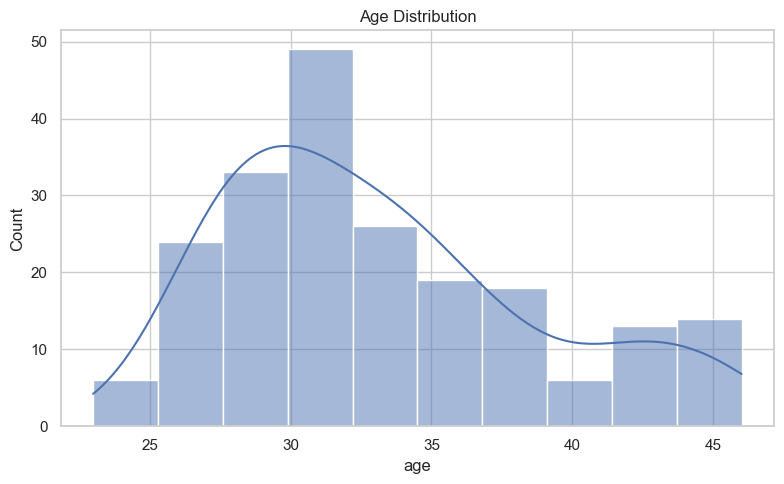

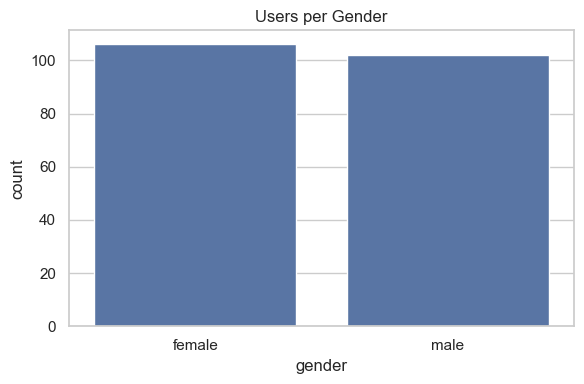

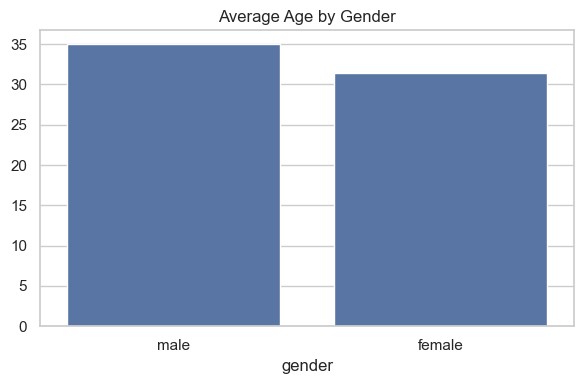

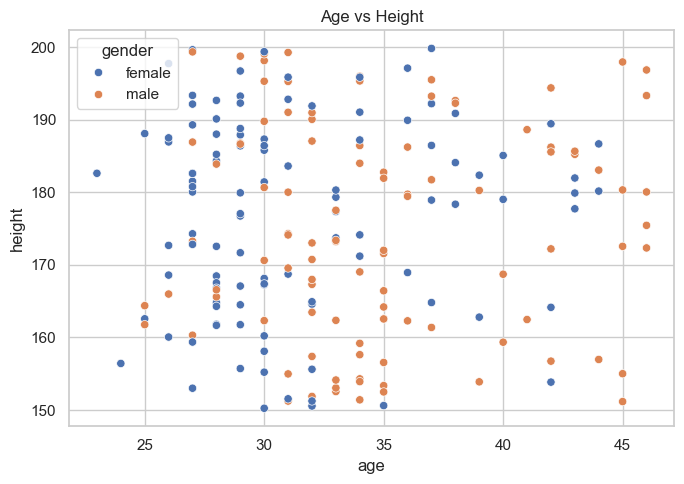

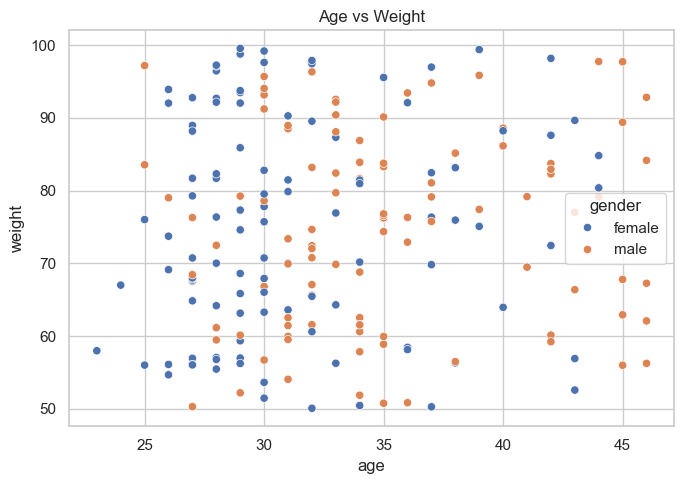

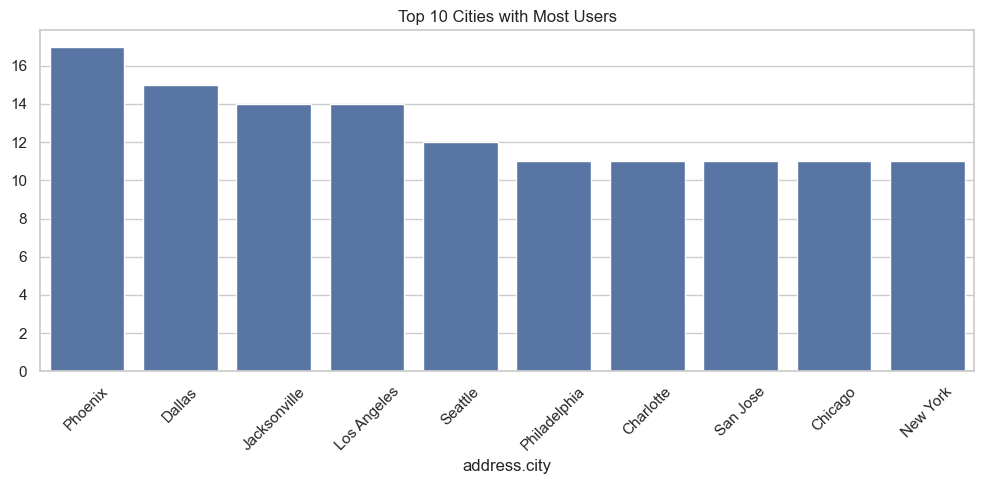


 Plots saved in plots/ folder
 Project finished.


In [14]:
sns.set(style="whitegrid")
os.makedirs("plots", exist_ok=True)

# Plot 1: Age Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["age"], kde=True)
plt.title("Age Distribution")
plt.tight_layout()
plt.savefig("plots/plot1_age_distribution.png")
plt.show()

# Plot 2: Users per Gender
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="gender")
plt.title("Users per Gender")
plt.tight_layout()
plt.savefig("plots/plot2_users_per_gender.png")
plt.show()

# Plot 3: Average Age by Gender
plt.figure(figsize=(6, 4))
sns.barplot(x=avg_age_gender.index, y=avg_age_gender.values)
plt.title("Average Age by Gender")
plt.tight_layout()
plt.savefig("plots/plot3_avg_age_by_gender.png")
plt.show()

# Plot 4: Age vs Height (Scatter)
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="age", y="height", hue="gender")
plt.title("Age vs Height")
plt.tight_layout()
plt.savefig("plots/plot4_age_vs_height.png")
plt.show()

# Plot 5: Age vs Weight (Scatter)
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="age", y="weight", hue="gender")
plt.title("Age vs Weight")
plt.tight_layout()
plt.savefig("plots/plot5_age_vs_weight.png")
plt.show()

# Plot 6 (Bonus): Top 10 Cities (Bar)
if top_cities is not None:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_cities.index, y=top_cities.values)
    plt.xticks(rotation=45)
    plt.title("Top 10 Cities with Most Users")
    plt.tight_layout()
    plt.savefig("plots/plot6_top10_cities.png")
    plt.show()

print("\n Plots saved in plots/ folder")
print(" Project finished.")